<a href="https://colab.research.google.com/github/ShinAsakawa/ShinAsakawa.github.io/blob/master/2022notebooks/2022_0625bit_faster_rcnn_devidation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%config InlineBackend.figure_format = 'retina'
try:
    import ipynbname
except ImportError:
    !pip install ipynbname > /dev/null
!git clone https://github.com/ShinAsakawa/bit

import bit
isColab = a_utils.isColab

In [ ]:
import os
import sys
import shutil
import typing
import cv2
import glob
from tqdm.notebook import tqdm

if isColab:
    from PIL import ImageFont
    from glob import glob

    !pip install pycocotools --quiet
    !git clone https://github.com/pytorch/vision.git
    !git checkout v0.3.0

    # Download TorchVision repo to use some files from references/detection
    # os.symlink(src,dst) にした方が良いかも
    !cp vision/references/detection/utils.py ./
    !cp vision/references/detection/transforms.py ./
    !cp vision/references/detection/coco_eval.py ./
    !cp vision/references/detection/engine.py ./
    !cp vision/references/detection/coco_utils.py ./
    
    !pip install japanize_matplotlib
    #!pip install albumentataions  # 2022_0604 一時的に中断 colab でエラー発生のため
    
    # 自作ライブラリ
    !git clone https://github.com/ShinAsakawa/bit.git

    # Noto fonts のダウンロードとインストール
    !mkdir Noto_JP_fonts
    !wget https://noto-website-2.storage.googleapis.com/pkgs/NotoSerifJP.zip
    !wget https://noto-website-2.storage.googleapis.com/pkgs/NotoSansJP.zip
    !unzip NotoSerifJP.zip -d Noto_JP_fonts
    !unzip -o NotoSansJP.zip -d Noto_JP_fonts  # `-o` means overwrite 
    !mv Noto_JP_fonts bit
    !mkdir data
    
    noto_font_dir = './bit/Noto_JP_fonts'
    notofonts_fnames = glob(os.path.join(noto_font_dir,'*otf'))
    notofonts = {fname.split('/')[-1].split('.')[0]:{'fname':fname} for fname in notofonts_fnames}
    for fontname in notofonts.keys():
        notofonts[fontname]['data'] = ImageFont.truetype(notofonts[fontname]['fname'])
else:
    # 自分のリポジトリからシンボリックリンクで代用
    for file in ['engine.py', 'utils.py', 'coco_utils.py', 'transforms.py', 'coco_eval.py']:
        if not os.path.exists(file):
            _file = os.path.join('../2020pytorch_vision.git/reference/detection/', file)
            !ln -s ../2020pytorch_vision.git/references/detection/engine.py .
            !ln -s ../2020pytorch_vision.git/references/detection/utils.py .
            !ln -s ../2020pytorch_vision.git/references/detection/coco_utils.py .
            !ln -s ../2020pytorch_vision.git/references/detection/transforms.py .
            !ln -s ../2020pytorch_vision.git/references/detection/coco_eval.py .
            
            
# https://github.com/amikelive/coco-labels を参考に日本語訳したもの 全 91 種類
CLASSES = [
    '背景',                                                       # 0
    '人', '自転車', '車', 'バイク', '飛行機',                        # [01-05]
    'バス', '電車', 'トラック','ボート', '信号機',                    # [06-10]
    '消火栓', '道路標識', '停止サイン', 'パーキングメーター', 'ベンチ',   # [11-15]
    '鳥', '猫', '犬', '馬', '羊',                                   # [16-20]
    '牛', 'ゾウ', '熊',  'シマウマ', 'キリン',                        # [21-25]
    '帽子', 'リュックサック', '傘', '靴', 'メガネ',                    # [26-30]
    'ハンドバッグ',  'ネクタイ', 'スーツケース', 'フリスビー', 'スキー',   # [31-35
    'スノーボード','スポーツボール','凧', '野球バット', '野球グローブ',    # [36-40]
    'スケートボード', 'サーフボード', 'テニスラケット', 'ボトル', '皿',    # [41-45]
     'ワイングラス', 'カップ', 'フォーク', 'ナイフ', 'スプーン',          # [46-50]
    'ボウル', 'バナナ', 'りんご', 'サンドイッチ', 'オレンジ',            # [51-55]
    'ブロッコリー', 'ニンジン', 'ホットドッグ', 'ピザ', 'ドーナツ',      # [56-60]
    'ケーキ', '椅子', 'ソファ', '鉢植え', 'ベッド',                   # [51-65]
    '鏡', 'ダイニングテーブル', '窓', 'デスク', 'トイレ',              # [66-70]
    'ドア', 'テレビ', 'ノートパソコン', 'マウス', 'リモコン',          # [71-75]
    'キーボード',  '携帯電話', '電子レンジ', 'コンロ', 'トースター',    # [76-80]
    '洗面台', '冷蔵庫', 'ミキサー', '本', '時計',                    # [81-85]
    '花瓶', 'ハサミ', 'テディベア', 'ドライヤー', '歯ブラシ']          # [85-90]

# DETR のサンプルプログラムを借用
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]
COLORS = COLORS * 100

In [6]:
# ライブラリのインポート
import os
import random
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as patches
try:
    import japanize_matplotlib
except ImportError:
    !pip install japanize_matplotlib
    import japanize_matplotlib
    

# torchvision ライブラリ
import torch
import torchvision
from torchvision import transforms as torchtrans  
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
#from torchvision.models.detection import fasterrcnn_resnet50_fpn

# ヘルパライブラリをインポート
from engine import train_one_epoch, evaluate
import utils
import transforms as T

In [7]:
from bit import BIT

if isColab:
    bit = BIT(fontdata=notofonts)
else:
    bit = BIT()

In [ ]:
bit.show_original_image()

In [9]:
def get_object_detection_model(num_classes):
    """see https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html"""
    # MS-COCO で事前に学習させたモデルを読み込み
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # 分類器の入力特徴数の取得
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    print(f'変換前 model.roi_heads:{model.roi_heads}')

    # 事前学習済頭部を新しいものに置き換え
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 
    print(f'変換後 model.roi_heads:{model.roi_heads}')

    return model

num_classes = len(bit.symbols)
bit_model = get_object_detection_model(num_classes)
print(f'num_classes:{num_classes}, bit.symbols:{bit.symbols}')
#bit_model.roi_heads

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

変換前 model.roi_heads:RoIHeads(
  (box_roi_pool): MultiScaleRoIAlign(featmap_names=['0', '1', '2', '3'], output_size=(7, 7), sampling_ratio=2)
  (box_head): TwoMLPHead(
    (fc6): Linear(in_features=12544, out_features=1024, bias=True)
    (fc7): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (box_predictor): FastRCNNPredictor(
    (cls_score): Linear(in_features=1024, out_features=91, bias=True)
    (bbox_pred): Linear(in_features=1024, out_features=364, bias=True)
  )
)
変換後 model.roi_heads:RoIHeads(
  (box_roi_pool): MultiScaleRoIAlign(featmap_names=['0', '1', '2', '3'], output_size=(7, 7), sampling_ratio=2)
  (box_head): TwoMLPHead(
    (fc6): Linear(in_features=12544, out_features=1024, bias=True)
    (fc7): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (box_predictor): FastRCNNPredictor(
    (cls_score): Linear(in_features=1024, out_features=49, bias=True)
    (bbox_pred): Linear(in_features=1024, out_features=196, bias=True)
  )
)
num_classes:49, bit.sy

In [11]:
# ユーティリティ関数群を輸入するための Google Drive の認証をする準備
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth

from pydrive.drive import GoogleDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [12]:
# 認証キーを取得してください。komazawa-u.ac.jp のアカウントである必要があります。
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [13]:
# Google Drive から zip ファイルを取得します
#https://drive.google.com/file/d/1ZgBrtZixree4YnXsRiQK6IRXreHdILzd/view?usp=sharing
download = drive.CreateFile({'id': '1ZgBrtZixree4YnXsRiQK6IRXreHdILzd'})
download.GetContentFile('2022_0620fine_tuned_bit_line_bisection.cpt')

In [14]:
pretrained_fname = '2022_0620fine_tuned_bit_line_bisection.cpt'
bit_model.load_state_dict(torch.load(pretrained_fname)['model'])

<All keys matched successfully>

In [15]:
images, bboxes = bit.make_line_bisection_task_images(N=1, n_lines=3)
img = images[0] 

In [ ]:
plt.figure(figsize=(8,8))
plt.axis('off')
plt.imshow(img);

In [20]:
import PIL

def apply_nms(orig_prediction, iou_thresh=0.3):
    
    keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)
    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]
    return final_prediction


def torch_to_pil(img):
    """torchtensor を PIL 画像に変換する関数"""
    return torchtrans.ToPILImage()(img).convert('RGB')


def plot_img_bbox(img, target, title=None):
    """画像中のバウンディングボックスを可視化する関数"""
    # バウンディングボックスは以下のように定義されます: x-min y-min 幅 高さ
    fig, ax = plt.subplots(1,1)
    fig.set_size_inches(7,7)
    ax.imshow(img)
    print(target)
    
    for box in target['boxes']:
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 4,
                                 edgecolor = 'red',
                                 facecolor = 'none')

        # 画像上にバウンディングボックスを描画 # Draw the bounding box on top of the image
        ax.add_patch(rect)
        
    if title != None:
        ax.set_title(title)
    plt.show()
    
    
def draw_center_mark(img_pt:torch.Tensor=None,
                     prediction:dict=None,
                     check_mark_offset:int=6,
                     check_mark_width:int=4,
                     check_mark_color:tuple=(0,255,0),
                     title=None,
                     img:PIL.Image=None,
                    ):

    if img == None:
        img = torch_to_pil(img_pt)
    _draw = PIL.ImageDraw.Draw(img)

    boxes = prediction['boxes']
    for box in boxes:
        left, top, right, bottom = box.clone().numpy()
        #print(left,top,right,bottom)
        h_center = int((right - left)/2 + left)
        v_center = int((bottom - top)/2 + top)
    
        x0 = h_center - check_mark_offset
        y0 = v_center - check_mark_offset
        x1 = h_center + check_mark_offset
        y1 = v_center + check_mark_offset
        _draw.line(xy=[(x0,y0),(x1,y1)], fill=check_mark_color, width=check_mark_width, joint=None)
    
    return img, _draw
    

In [21]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


def make_a_prediction(n_lines:int=3):
    images, bboxes = bit.make_line_bisection_task_images(N=1, n_lines=n_lines)
    img = images[0] 
    img_rgb = cv2.cvtColor(np.array(img), cv2.COLOR_BGR2RGB).astype(np.float32)
    img_res = cv2.resize(img_rgb, (224, 224), cv2.INTER_AREA)
    img_res /= 255.0
    img_pt = torch.Tensor(img_res).permute(2,0,1)

    bit_model.eval()
    with torch.no_grad():
        prediction = bit_model([img_pt.to(device)])[0]
        
    return img, img_pt, prediction
    
    
def make_a_stim_then_predict(n_lines:int=3,
                             verbose:bool=False,
                             isDraw:bool=False,
                            ):

    img, img_pt, prediction = make_a_prediction(n_lines=n_lines)
    if verbose:
        plot_img_bbox(torch_to_pil(img_pt), 
                      {'boxes':bboxes[0]}, title="正解")

    _img, _draw = draw_center_mark(img_pt=img_pt, prediction=prediction, 
                                   check_mark_width=2,
                                   check_mark_color='red')
    if isDraw:
        plt.figure(figsize=(7,7))
        plt.title('モデル')
        plt.imshow(_img)
        plt.show()
    return prediction, _img, _draw
    
prediction, img, draw = make_a_stim_then_predict()
print(prediction)

{'boxes': tensor([[ 23.4070, 130.5566, 182.8368, 140.1834],
        [ 25.0321,  59.6141, 186.2895,  69.2280]]), 'labels': tensor([1, 1]), 'scores': tensor([0.9991, 0.9989])}


In [ ]:
img, _draw = draw_center_mark(img_pt=img_pt, prediction=prediction, check_mark_color='red')
plt.figure(figsize=(7,7))
plt.title('モデル')
plt.imshow(_img); 


{'boxes': tensor([[ 16.4224,  82.1376, 181.6965,  91.7548],
        [ 24.7220,  64.2064, 189.7571,  73.7632],
        [ 24.8122,  43.2432, 187.9827,  52.6979]]), 'labels': tensor([1, 1, 1]), 'scores': tensor([0.9964, 0.9959, 0.9952])}


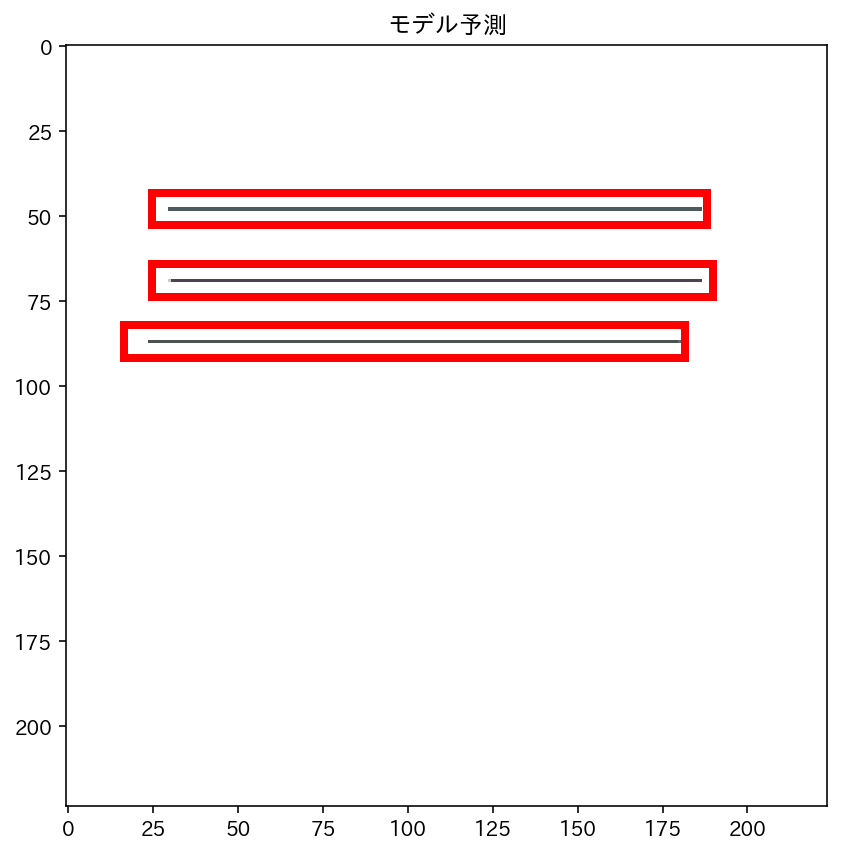

In [34]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

images, bboxes = bit.make_line_bisection_task_images(N=1, n_lines=3)
img = images[0] 
img_rgb = cv2.cvtColor(np.array(img), cv2.COLOR_BGR2RGB).astype(np.float32)
img_res = cv2.resize(img_rgb, (224, 224), cv2.INTER_AREA)
img_res /= 255.0
img_pt = torch.Tensor(img_res).permute(2,0,1)
#img_pt = torch.Tensor(img).permute(2,0,1)
#img_pt = torch.Tensor(np.array(img)/255).permute(2,0,1)

bit_model.eval()
with torch.no_grad():
    prediction = bit_model([img_pt.to(device)])[0]
    
#plot_img_bbox(torch_to_pil(img_pt), {'boxes':bboxes[0]}, title="グランドトルース")
#nms_prediction = apply_nms(prediction, iou_thresh=0.01)
plot_img_bbox(torch_to_pil(img_pt), prediction, title="モデル予測")
#nms_prediction = apply_nms(prediction, iou_thresh=0.01)
#plot_img_bbox(torch_to_pil(img_pt), nms_prediction, title="モデル予測")

In [ ]:
_img, _draw = draw_center_mark(img_pt=img_pt, prediction=prediction, check_mark_color='red')
plt.figure(figsize=(7,7))
plt.title('モデル')
plt.imshow(_img)    


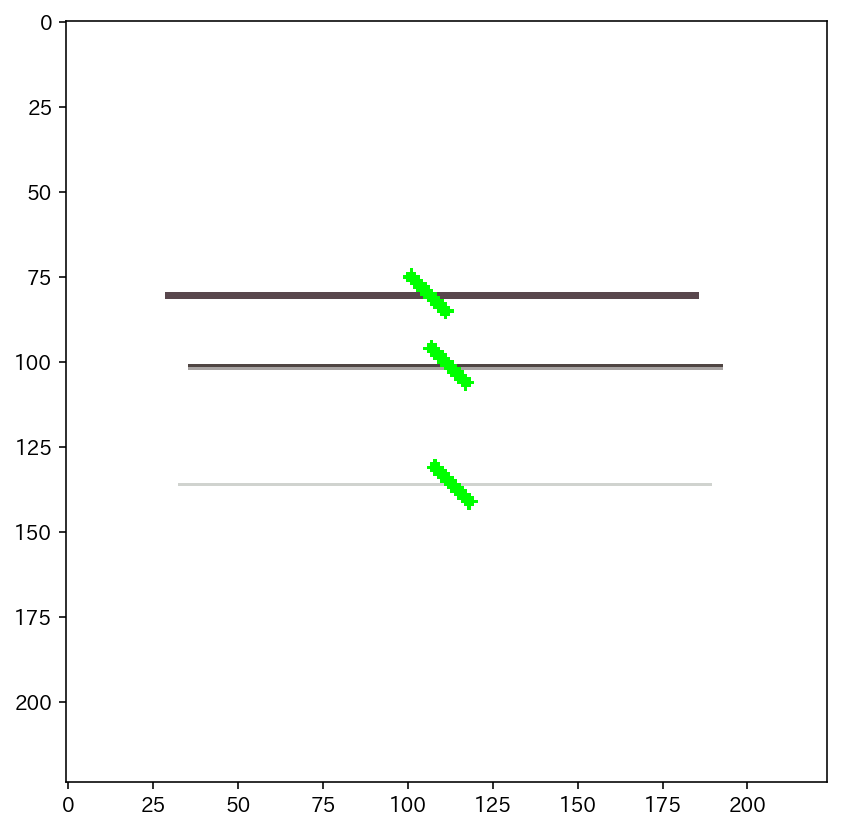

In [31]:
def draw_center_mark(img_pt:torch.Tensor=None,
                     prediction:dict=None,
                     check_mark_offset:int=6,
                     check_mark_width:int=4,
                     check_mark_color:tuple=(0,255,0),
                    ):
                     
    _img = torch_to_pil(img_pt)
    _draw = PIL.ImageDraw.Draw(_img)

    boxes = prediction['boxes']
    for box in boxes:
        left, top, right, bottom = box.clone().numpy()
        #print(left,top,right,bottom)
        h_center = int((right - left)/2 + left)
        v_center = int((bottom - top)/2 + top)
    
        x0 = h_center - check_mark_offset
        y0 = v_center - check_mark_offset
        x1 = h_center + check_mark_offset
        y1 = v_center + check_mark_offset
        _draw.line(xy=[(x0,y0),(x1,y1)], fill=check_mark_color, width=check_mark_width, joint=None)
        #print(h_center, v_center)
    #print(boxes)  
    
    return _img, _draw

_img, _draw = draw_center_mark(img_pt=img_pt, prediction=prediction)
plt.figure(figsize=(7,7))
plt.imshow(_img)    
    

In [ ]:
type(prediction)

dict